In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
include("/home/javier/Desktop/alpcahus/alpcahus.jl")
include("/home/javier/Desktop/alpcahus/cluster.jl")
include("/home/javier/Desktop/alpcahus/otherMethods.jl")
include("/home/javier/Desktop/alpcahus/adssc.jl")

lsr (generic function with 1 method)

In [2]:
Y1, v1full = load("astroData_z2_bal.jld","Yfull", "vfull") # z2_bal
Y2, v2full = load("astroData_z1.jld", "Yfull", "vfull");
tmp = randperm(MersenneTwister(4321), size(Y2)[2])[1:2500]
Y2 = Y2[:,tmp];
v2full = v2full[tmp];
tmp = randperm(MersenneTwister(4321), size(Y1)[2])[1:2500]
Y1 = Y1[51:281-50,tmp];
v1full = v1full[tmp]
K = 2;
Y1test = Y1[:,1:2500]
Y2test = Y2[:,1:2500];

In [3]:
# params
params = load("params1.jld", "params");

In [4]:
Utrue = []
push!(Utrue,fastALPCAH(Y1test[:,1:1000],params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
push!(Utrue,fastALPCAH(Y2test[:,1:1000],params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
nothing;

In [5]:
methodsList = ["Noisy Oracle" "EKSS" "ALPCAHUS" "EKSS (B=1)" "ALPCAHUS (B=1)" "ADSSC" "TSC" "K-means"]
num_methods = length(methodsList)
num_trials = 100; ntest = 200 

200

In [6]:
test_errors = zeros(num_methods,1,num_trials)
p = Progress(num_trials; dt=1)
for trial=1:num_trials
    shuffleIndex1 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex2 = shuffle(1:size(Y2test)[2])[1:ntest]
    shuffleIndex3 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex4 = shuffle(1:size(Y2test)[2])[1:ntest]
    
    
    test1 = @view Y1test[:,shuffleIndex1]
    test2 = @view Y2test[:,shuffleIndex2]
    #train1 = @view Y1train[:,shuffleIndex3]
    #train2 = @view Y2train[:,shuffleIndex4]
    Ytest = hcat(test1,test2)
    #Ytrain = hcat(train1,train2)
    C = vcat(1*ones(Int, ntest), 2*ones(Int, ntest))

    # METHODS
    # Noisy Oracle
    U = []
    for k=1:K
        push!(U,fastALPCAH(Ytest[:,C .== k], params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
    end
    C_oracle = clusterAssignment(Ytest, U, K);
    oracleError = clusterError(C,C_oracle)
    # ekss trial
    C_ekss = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["ekss"], T=3, subspaceMethod=:pca, finalStep=false)
    ekssError = clusterError(C,C_ekss)
    # alpcahus trail
    C_alpcahus = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["alpcahus"], T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true) 
    alpcahusError = clusterError(C,C_alpcahus)
    # ekss smart init trial
    C_kss = ALPCAHUS(Ytest, K, [params["rank"];params["rank"]]; B=1, q=params["ekss"], T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
    kssError = clusterError(C, C_kss)
    # alpcahus smart init trail
    C_alpcah = ALPCAHUS(Ytest,K, [params["rank"];params["rank"]]; B=1, q=params["alpcahus"], T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
    alpcahError = clusterError(C, C_alpcah)
    # adssc
    C_adssc = adsscWrapper(Ytest, params["adssc"][1], params["adssc"][2]; K=2)
    adsscError = clusterError(C,C_adssc)
    # tsc
    C_tsc = tscWrapper(Ytest, params["tsc"]; K=2)
    tscError = clusterError(C,C_tsc)
    # MPPCA
    C_mppca = MPPCA_Wrapper(Ytest, K, params["tsc"], params["rank"]) #kmeans(Elkan(), Ytest, 2; k_init="k-means++").assignments
    mppcaError = clusterError(C,C_mppca)

    # save results
    test_errors[1,1,trial] = oracleError
    test_errors[2,1,trial] = ekssError
    test_errors[3,1,trial] = alpcahusError
    test_errors[4,1,trial] = kssError
    test_errors[5,1,trial] = alpcahError
    test_errors[6,1,trial] = adsscError
    test_errors[7,1,trial] = tscError
    test_errors[8,1,trial] = mppcaError
    
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:19:18


In [13]:
save("trialData1.jld", "test_errors", test_errors);

In [31]:
test_errors = load("trialData1.jld", "test_errors");
test_errors = test_errors[1:7,1,:]

7×100 Matrix{Float64}:
  5.5    4.5   48.5    4.75   3.75  …   4.0    5.25  42.0   48.75   4.75
 38.25  29.5   38.5   22.5   14.5      17.25  24.75  34.25  38.25  22.5
  5.25   4.5   49.0    6.25   4.5       5.5    4.5   48.25   3.75   6.0
 39.25  10.0   48.75  49.25  45.0      49.75   7.0   47.25   2.5   30.5
  6.75   5.0   48.75  26.25   6.25      6.0    4.75  45.75   3.75   7.75
  8.75  11.0   17.25  12.0   49.5   …  49.5   16.25  49.25  17.5   17.0
 14.0   26.25  16.0   14.5   16.5      17.25  14.5   16.5   19.75  18.5

In [32]:
test_errors2 = deepcopy(test_errors)
test_errors2[1,:] = test_errors[1,:]
test_errors2[2,:] = test_errors[4,:]
test_errors2[3,:] = test_errors[2,:]
test_errors2[4,:] = test_errors[6,:]
test_errors2[5,:] = test_errors[7,:]
test_errors2[6,:] = test_errors[5,:]
test_errors2[7,:] = test_errors[3,:];


In [33]:
colors = palette(:default)

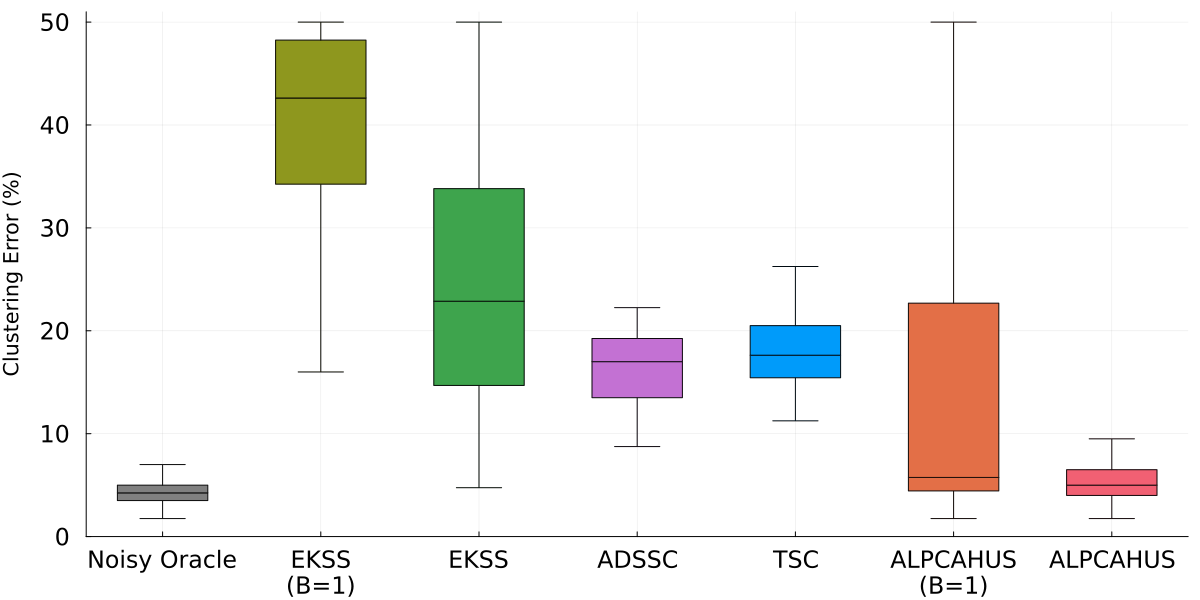

In [36]:
boxplots = []
titles = [""]
methodsList = ["Noisy Oracle" " EKSS \n(B=1)" "EKSS" "ADSSC" "TSC" " ALPCAHUS \n(B=1)" "ALPCAHUS"]
#p = plot(size=(300,300))
p = boxplot(methodsList, test_errors2', leg = false,title=titles[1],
    color=[:gray colors[10] colors[3] colors[4] colors[1] colors[2] colors[end-2]],ylabel="Clustering Error (%)", outliers=false)
push!(boxplots,p)  

using Plots.PlotMeasures
# size=(2100,300)
plot_boxes = plot(boxplots..., size=(1200,600),
                    left_margin = 5mm,
                    bottom_margin = 5mm,
                    legendfontpointsize=14,xtickfontsize=16,ytickfontsize=16,guidefontsize=14,titlefontsize=14,
                    ylim = (0,51)
                    )
#savefig("clustering_results_bal.svg")

In [40]:
using Distributions
mean(test_errors[1:end-1,1,:]', dims=1)

1×7 Matrix{Float64}:
 7.6075  23.7925  6.2825  38.5225  14.4475  21.12  18.1675

In [32]:
shuffleIndex1 = shuffle(1:size(Y1test)[2])[1:ntest]
shuffleIndex2 = shuffle(1:size(Y2test)[2])[1:ntest]
test1 = @view Y1test[:,shuffleIndex1]
test2 = @view Y2test[:,shuffleIndex2]
Ytest = hcat(test1,test2);
C = vcat(1*ones(Int, ntest), 2*ones(Int, ntest));

In [38]:
C_alpcah = ALPCAHUS(Ytest,K, [params["rank"];params["rank"]]; B=1, q=params["alpcahus"], T=10, alpcahIter=5, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
clusterError(C, C_alpcah)

19.5

In [46]:
C_alpcahus = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=16, q=params["alpcahus"], T=3, alpcahIter=5, subspaceMethod=:alpcah, finalStep=true) 
clusterError(C,C_alpcahus)

4.0

In [47]:
using BenchmarkTools
trialEKSS = @benchmark ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=16, q=params["ekss"], T=3, subspaceMethod=:pca, finalStep=false)
trialALPCAHUS = @benchmark ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=16, q=params["alpcahus"], T=3, alpcahIter=5, subspaceMethod=:alpcah, finalStep=true) 
trialSmartEKSS = @benchmark ALPCAHUS(Ytest, K, [params["rank"];params["rank"]]; B=1, q=params["ekss"], T=10, subspaceMethod=:pca, finalStep=false, spectralStart=true)
trialSmartALPCAHUS = @benchmark ALPCAHUS(Ytest,K, [params["rank"];params["rank"]]; B=1, q=params["alpcahus"], T=10, alpcahIter=5, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
trialADSSC = @benchmark adsscWrapper(Ytest, params["adssc"][1], params["adssc"][2]; K=2)
trialTSC = @benchmark tscWrapper(Ytest, params["tsc"]; K=2)

BenchmarkTools.Trial: 154 samples with 1 evaluation.
 Range (min … max):  29.830 ms … 38.739 ms  ┊ GC (min … max): 6.02% … 4.63%
 Time  (median):     32.271 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.476 ms ±  1.284 ms  ┊ GC (mean ± σ):  2.03% ± 2.64%

                            ▄▃▅█▃                              
  ▄▃▆▆▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇▄▇█████▆▆▄▁▁▁▁▁▁▁▁▁▃▃▁▅▇▃▄▇▅▇▄▄▁▃▁▃ ▃
  29.8 ms         Histogram: frequency by time        34.8 ms <

 Memory estimate: 16.49 MiB, allocs estimate: 3823.

In [48]:
timeEKSS, memoryEKSS = round((median(trialEKSS).time)/1e6, digits=1), round((median(trialEKSS).memory/1024)/1024, digits=1)
timeALPCAHUS, memoryALPCAHUS = round((median(trialALPCAHUS).time)/1e6, digits=1), round((median(trialALPCAHUS).memory/1024)/1024, digits=1)
timeSmartEKSS, memorySmartEKSS = round((median(trialSmartEKSS).time)/1e6, digits=1), round((median(trialSmartEKSS).memory/1024)/1024, digits=1)
timeSmartALPCAHUS, memorySmartALPCAHUS = round((median(trialSmartALPCAHUS).time)/1e6, digits=1), round((median(trialSmartALPCAHUS).memory/1024)/1024, digits=1)
timeADSSC, memoryADSSC = round((median(trialADSSC).time)/1e6, digits=1), round((median(trialADSSC).memory/1024)/1024, digits=1);
timeTSC, memoryTSC = round((median(trialTSC).time)/1e6, digits=1), round((median(trialTSC).memory/1024)/1024, digits=1);

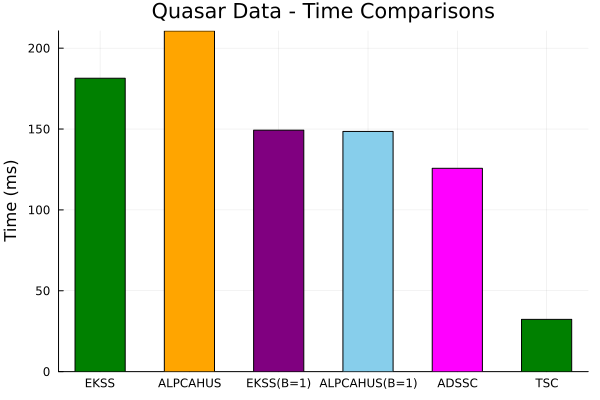

In [49]:
bar(["EKSS" "ALPCAHUS" "EKSS(B=1)" "ALPCAHUS(B=1)" "ADSSC" "TSC"], [timeEKSS timeALPCAHUS timeSmartEKSS timeSmartALPCAHUS timeADSSC timeTSC], leg = false,title="Quasar Data - Time Comparisons",color=[:green :orange :purple :skyblue :magenta], ylabel="Time (ms)", yticks = :native)
#savefig("result_time.pdf")

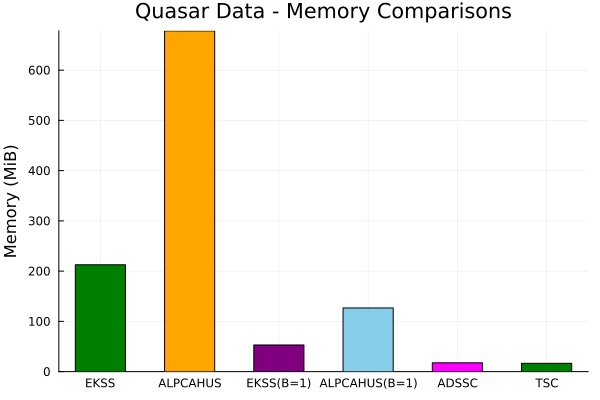

In [50]:
bar(["EKSS" "ALPCAHUS" "EKSS(B=1)" "ALPCAHUS(B=1)" "ADSSC" "TSC"], [memoryEKSS memoryALPCAHUS memorySmartEKSS memorySmartALPCAHUS memoryADSSC memoryTSC], leg = false,title="Quasar Data - Memory Comparisons",color=[:green :orange :purple :skyblue :magenta], ylabel="Memory (MiB)", yticks = :native)
#savefig("result_memory.pdf")

In [51]:
[timeEKSS timeALPCAHUS timeSmartEKSS timeSmartALPCAHUS timeADSSC timeTSC]

1×6 Matrix{Float64}:
 181.4  210.7  149.3  148.5  125.7  32.3

In [52]:
[memoryEKSS memoryALPCAHUS memorySmartEKSS memorySmartALPCAHUS memoryADSSC memoryTSC]

1×6 Matrix{Float64}:
 212.6  678.2  53.0  126.7  17.5  16.5

In [9]:
function affinityError(Ut::Matrix, U::Matrix)
    return norm(U*U' - Ut*Ut', 2)/norm(Ut*Ut', 2)
end
function PCA(A::Matrix, d::Int; alpcahIter::Int=100)
    if size(A)[2] >= d
        return svd(A).U[:,1:d]
    else
        return svd(A).U[:,1:size(A)[2]]
    end
end

PCA (generic function with 1 method)

In [7]:
Utrue = []
push!(Utrue,fastALPCAH(Y1test,params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
push!(Utrue,fastALPCAH(Y2test,params["rank"]; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
nothing;

In [25]:
num_methods = 7;
num_trials = 20; ntest = 400 
test_errors = zeros(num_methods,1,num_trials)
Yfull = hcat(Y1test, Y2test);
p = Progress(num_trials; dt=1)
for trial=1:num_trials
    shuffleIndex1 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex2 = shuffle(1:size(Y2test)[2])[1:ntest]
    shuffleIndex3 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex4 = shuffle(1:size(Y2test)[2])[1:ntest]
    
    
    test1 = @view Y1test[:,shuffleIndex1]
    test2 = @view Y2test[:,shuffleIndex2]
    #train1 = @view Y1train[:,shuffleIndex3]
    #train2 = @view Y2train[:,shuffleIndex4]
    Ytest = hcat(test1,test2)
    #Ytrain = hcat(train1,train2)
    C = vcat(1*ones(Int, ntest), 2*ones(Int, ntest))

    # METHODS
    # Noisy Oracle
    U = []
    for k=1:K
        push!(U,fastALPCAH(Ytest[:,C .== k], params["rank"]; alpcahIter= 100))
    end
    C_oracle = clusterAssignment(Ytest, U, K);
    # ekss trial
    C_ekss = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["ekss"], T=3, subspaceMethod=:pca, finalStep=false)
    # alpcahus trail
    C_alpcahus = ALPCAHUS(Ytest,K,[params["rank"];params["rank"]]; B=64, q=params["alpcahus"], T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true) 
    # ekss smart init trial
    C_kss = ALPCAHUS(Ytest, K, [params["rank"];params["rank"]]; B=1, q=params["ekss"], T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
    # alpcahus smart init trail
    C_alpcah = ALPCAHUS(Ytest,K, [params["rank"];params["rank"]]; B=1, q=params["alpcahus"], T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
    # adssc
    C_adssc = adsscWrapper(Ytest, params["adssc"][1], params["adssc"][2]; K=2)
    # tsc
    C_tsc = tscWrapper(Ytest, params["tsc"]; K=2)

    Uoracle = []
    Uekss = []
    Ualpcahus = []
    Ukss = []
    Ualpcah = []
    Uadssc = []
    Utsc = []
    for k=1:K
        push!(Uoracle, fastALPCAH(Ytest[:, C_oracle .== k], params["rank"]; alpcahIter= 100))
        push!(Uekss, fastALPCAH(Ytest[:, C_ekss .== k], params["rank"]; alpcahIter= 100))
        push!(Ualpcahus, fastALPCAH(Ytest[:, C_alpcahus .== k], params["rank"]; alpcahIter= 100))
        push!(Ukss, fastALPCAH(Ytest[:, C_kss .== k], params["rank"]; alpcahIter= 100))
        push!(Ualpcah, fastALPCAH(Ytest[:, C_alpcah .== k], params["rank"]; alpcahIter= 100))
        push!(Uadssc, fastALPCAH(Ytest[:, C_adssc .== k], params["rank"]; alpcahIter= 100))
        push!(Utsc, fastALPCAH(Ytest[:, C_tsc .== k], params["rank"]; alpcahIter= 100))
    end

    C_oracle = clusterAssignment(Yfull, Uoracle, K)
    C_ekss = clusterAssignment(Yfull, Uekss, K)
    C_alpcahus = clusterAssignment(Yfull, Ualpcahus, K)
    C_kss = clusterAssignment(Yfull, Ukss, K)
    C_alpcah = clusterAssignment(Yfull, Ualpcah, K)
    C_adssc = clusterAssignment(Yfull, Uadssc, K)
    C_tsc = clusterAssignment(Yfull, Utsc, K)

    Uoracle = []
    Uekss = []
    Ualpcahus = []
    Ukss = []
    Ualpcah = []
    Uadssc = []
    Utsc = []
    for k=1:K
        push!(Uoracle, fastALPCAH(Yfull[:, C_oracle .== k], params["rank"]; alpcahIter= 100))
        push!(Uekss, fastALPCAH(Yfull[:, C_ekss .== k], params["rank"]; alpcahIter= 100))
        push!(Ualpcahus, fastALPCAH(Yfull[:, C_alpcahus .== k], params["rank"]; alpcahIter= 100))
        push!(Ukss, fastALPCAH(Yfull[:, C_kss .== k], params["rank"]; alpcahIter= 100))
        push!(Ualpcah, fastALPCAH(Yfull[:, C_alpcah .== k], params["rank"]; alpcahIter= 100))
        push!(Uadssc, fastALPCAH(Yfull[:, C_adssc .== k], params["rank"]; alpcahIter= 100))
        push!(Utsc, fastALPCAH(Yfull[:, C_tsc .== k], params["rank"]; alpcahIter= 100))
    end

    error1 = min(affinityError(Utrue[1], Uoracle[1]), affinityError(Utrue[1], Uoracle[2]))
    error2 = min(affinityError(Utrue[2], Uoracle[1]), affinityError(Utrue[2], Uoracle[2]))
    oracleError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Uekss[1]), affinityError(Utrue[1], Uekss[2]))
    error2 = min(affinityError(Utrue[2], Uekss[1]), affinityError(Utrue[2], Uekss[2]))
    ekssError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Ualpcahus[1]), affinityError(Utrue[1], Ualpcahus[2]))
    error2 = min(affinityError(Utrue[2], Ualpcahus[1]), affinityError(Utrue[2], Ualpcahus[2]))
    alpcahusError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Ukss[1]), affinityError(Utrue[1], Ukss[2]))
    error2 = min(affinityError(Utrue[2], Ukss[1]), affinityError(Utrue[2], Ukss[2]))
    kssError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Ualpcah[1]), affinityError(Utrue[1], Ualpcah[2]))
    error2 = min(affinityError(Utrue[2], Ualpcah[1]), affinityError(Utrue[2], Ualpcah[2]))
    alpcahError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Uadssc[1]), affinityError(Utrue[1], Uadssc[2]))
    error2 = min(affinityError(Utrue[2], Uadssc[1]), affinityError(Utrue[2], Uadssc[2]))
    adsscError = 0.5*(error1+error2)
    error1 = min(affinityError(Utrue[1], Utsc[1]), affinityError(Utrue[1], Utsc[2]))
    error2 = min(affinityError(Utrue[2], Utsc[1]), affinityError(Utrue[2], Utsc[2]))
    tscError = 0.5*(error1+error2)

    # save results
    test_errors[1,1,trial] = oracleError
    test_errors[2,1,trial] = ekssError
    test_errors[3,1,trial] = alpcahusError
    test_errors[4,1,trial] = kssError
    test_errors[5,1,trial] = alpcahError
    test_errors[6,1,trial] = adsscError
    test_errors[7,1,trial] = tscError
    
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:12:34


In [24]:
#save("trialData1_subspaces.jld", "test_errors", test_errors);

In [40]:
test_errors = load("trialData1_subspaces.jld", "test_errors")
test_errors = test_errors[1:7,1,:]

7×100 Matrix{Float64}:
 0.422102  0.437879  0.0584735  0.308396  …  0.0552996  0.199966  0.229177
 0.831468  0.7856    0.844831   0.815885     0.738959   0.848736  0.822353
 0.422112  0.207675  0.221786   0.317413     0.849118   0.266518  0.0508816
 0.846974  0.844513  0.845552   0.84446      0.844965   0.779704  0.844933
 0.132347  0.437879  0.793256   0.29458      0.46991    0.188467  0.221065
 0.787984  0.470122  0.844428   0.429434  …  0.523587   0.507143  0.766251
 0.411558  0.142885  0.544846   0.363637     0.417855   0.217869  0.511365

In [41]:
test_errors2 = deepcopy(test_errors)
test_errors2[1,:] = test_errors[1,:]
test_errors2[2,:] = test_errors[4,:]
test_errors2[3,:] = test_errors[2,:]
test_errors2[4,:] = test_errors[6,:]
test_errors2[5,:] = test_errors[7,:]
test_errors2[6,:] = test_errors[5,:]
test_errors2[7,:] = test_errors[3,:];

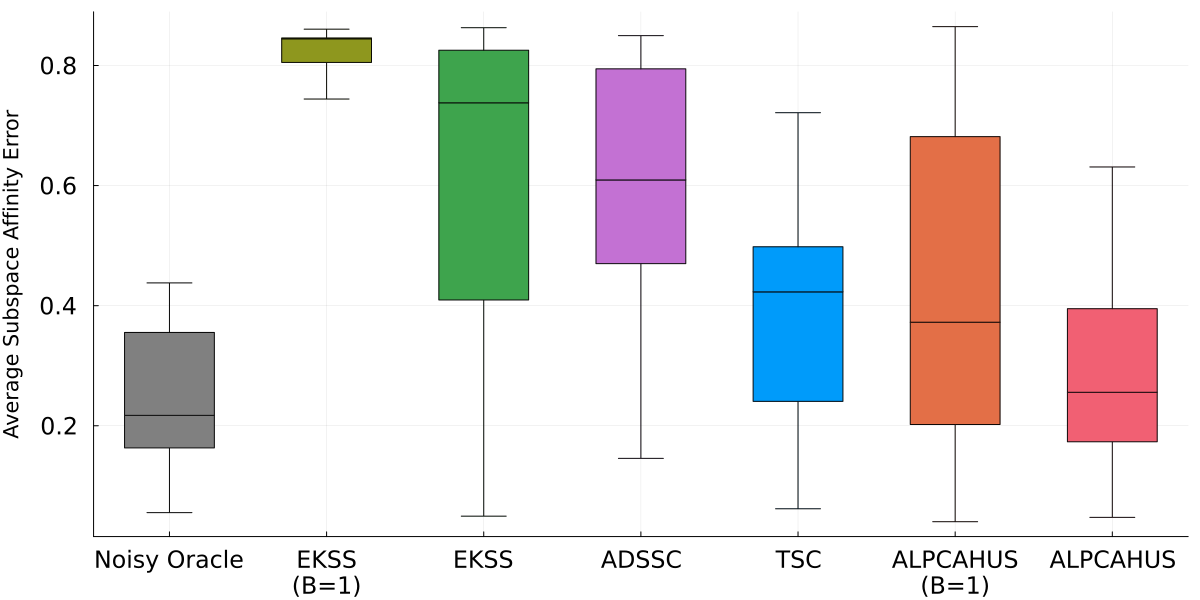

In [44]:
boxplots = []
titles = [""]
methodsList = ["Noisy Oracle" " EKSS \n(B=1)" "EKSS" "ADSSC" "TSC" " ALPCAHUS \n(B=1)" "ALPCAHUS"]
#p = plot(size=(300,300))
p = boxplot(methodsList, test_errors2', leg = false,title=titles[1],
    color=[:gray colors[10] colors[3] colors[4] colors[1] colors[2] colors[end-2]],ylabel="Average Subspace Affinity Error", outliers=false)
push!(boxplots,p)  

using Plots.PlotMeasures
# size=(2100,300)
plot_boxes = plot(boxplots..., size=(1200,600),
                    left_margin = 5mm,
                    bottom_margin = 5mm,
                    legendfontpointsize=14,xtickfontsize=16,ytickfontsize=16,guidefontsize=14,titlefontsize=14,
                    #ylim = (0,25)
                    )
#savefig("results_subspaces_bal.svg")

In [22]:
using Statistics
mean(test_errors[:,1,:]',dims=1)

1×7 Matrix{Float64}:
 0.255073  0.619668  0.284702  0.803314  0.431425  0.621923  0.396678